<a href="https://colab.research.google.com/github/spegas/Dacon/blob/main/LG_V1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

목적 : "작물 환경 데이터"와 "작물 병해 이미지"를 이용해 "작물의 종류", "병해의 종류", "병해의 진행 정도"를 진단하는 AI 모델 개발


결과물 양식 (두개의 컬럼이 존재 ['image','label'])

1. image : 이미지 파일 이름
2. label : "{작물 코드}\_{작물 상태 코드}\_{질병 피해 정도}" 형태의 문자열
"{crop}\_{disease}\_{risk}"

[평가 항목]

1. 모델 성능
  - 리더보드 Private 점수 : 30
  - 환경 데이터 사용 여부 : 10

2. 적용 가능성
  - 동작 속도 : 15
  - 모델&데이터 로딩 후 데이터 전처리 ~ 추론 ~ 결과 저장 시간 측정

3. 정보 공유
  - 코드 공유, 토론 및 답변 : 5

4. 자료
  - 제출 코드의 전처리, 학습, 추론, 설명 자료 : 각 5

5. 발표 내용, 시간 준수, 질의응답 : 20
  - 모델 창의성 / 모델의 한계 분석 등 포함

[해결해야 할 사항]
1. 이미지 용량이 너무 큼.
2. 학습시간이 오래 걸림.


[해결방법]
1. 이미지 용량이 너무 큼.
  - 이미지 일부만 학습 할 수 있는가.?
  - 
2. 학습시간이 오래 걸림
  - 다른 학습 모델이 있는가.?

In [1]:
# google driver에 있는 데이터 공유를 위한 설치 패키지
!pip install gdrive_dataset

In [2]:
# 예를 들어: https://drive.google.com/file/d/abcdefgABCDEFG1234567/view 이 있다면
# abcdefgABCDEFG1234567 이 위치가 file_id 입니다.

In [3]:
from gdrivedataset import loader

# file_id = # 이곳에 file_id 를 입력
file_id ='1DOYRWtzDlynJ0VJqDtdluzHXBzkJLZgE'
loader.load_from_google_drive(file_id)

========== files ============

data/train.csv
data/train.zip
data/sample_submission.csv
data/test.zip



In [ ]:
!unzip data/train.zip -d data

In [ ]:
!unzip data/test.zip -d data

In [6]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="0"

In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
from tqdm import tqdm
from glob import glob
import os
import json 
import torch
from torch import nn
from torchvision import models
from torch.utils.data import Dataset
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split

In [8]:
train_data_path_list = glob('data/train/*')

 -- train_data_path -- 
data/train/15141


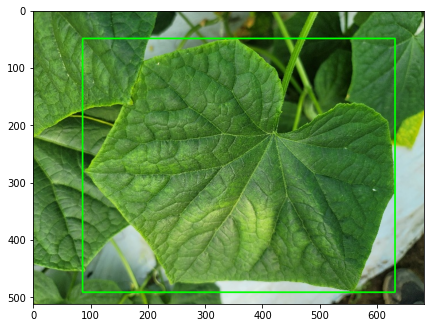

 -- train_data_path -- 
data/train/24422


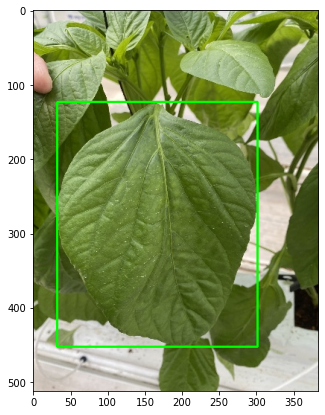

In [9]:
for train_data_path in train_data_path_list[:2]:
  print(" -- train_data_path -- ")
  print(train_data_path)

  sample_csv = pd.read_csv(glob(train_data_path+'/*.csv')[0])
  sample_image = cv2.imread(glob(train_data_path+'/*.jpg')[0])
  sample_json = json.load(open(glob(train_data_path+'/*.json')[0], 'r'))

  # visualize bbox
  plt.figure(figsize=(7,7))
  points = sample_json['annotations']['bbox'][0]
  part_points = sample_json['annotations']['part']
  img = cv2.cvtColor(sample_image, cv2.COLOR_BGR2RGB)

  cv2.rectangle(
      img,
      (int(points['x']), int(points['y'])),
      (int((points['x']+points['w'])), int((points['y']+points['h']))),
      (0, 255, 0),
      2
  )
  for part_point in part_points:
      point = part_point
      cv2.rectangle(
          img,
          (int(point['x']), int(point['y'])),
          (int((point['x']+point['w'])), int((point['y']+point['h']))),
          (255, 0, 0),
          1
      )
  plt.imshow(img)
  plt.show()

In [10]:
class Train_info:
    def __init__(self):
      self.train_num = None
      self.csv_file_list = None
      self.imagme_file_list = None
      self.json_file_list = None

    def set_train_num(self, num):
      self.train_num = str(num)

    def set_csv_file_list(self, file_list):
      self.csv_file_list = file_list

    def set_image_file_list(self, file_list):
      self.image_file_list = file_list

    def set_json_file_list(self, file_list):
      self.json_file_list = file_list

    def get_train_num(self):
      return self.train_num

    def get_csv_file_list(self):
      return self.csv_file_list

    def get_image_file_list(self):
      return self.image_file_list

    def get_json_file_list(self):
      return self.json_file_list

In [11]:
train_info_list = []

In [ ]:
for train_data_path in train_data_path_list:
  print(" -- train_data_path -- ")
  print(train_data_path)

  train_num = train_data_path.split('/')[-1]

  new_train_info = Train_info()
  new_train_info.set_train_num(train_num)
  new_train_info.set_csv_file_list(glob(train_data_path+'/*.csv'))
  new_train_info.set_image_file_list(glob(train_data_path+'/*.jpg'))
  new_train_info.set_json_file_list(glob(train_data_path+'/*.json'))

  train_info_list.append(new_train_info)

In [ ]:
for train_info in train_info_list:
  print(train_info)
  print(train_info.get_train_num())
  print(train_info.get_csv_file_list())
  print(train_info.get_image_file_list())
  print(train_info.get_json_file_list())

In [14]:
test_data_path_list = glob('data/test/*')

 -- test_data_path -- 
data/test/32799


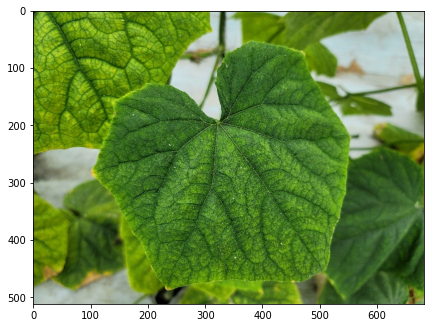

 -- test_data_path -- 
data/test/18518


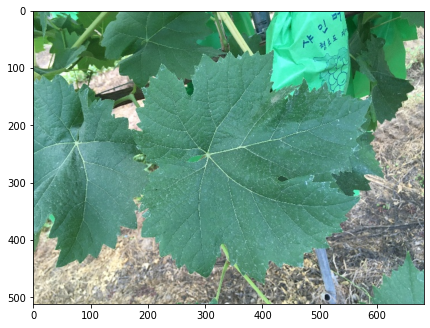

In [15]:
for test_data_path in test_data_path_list[:2]:
  print(" -- test_data_path -- ")
  print(test_data_path)

  sample_csv = pd.read_csv(glob(test_data_path+'/*.csv')[0])
  sample_image = cv2.imread(glob(test_data_path+'/*.jpg')[0])
  # sample_json = json.load(open(glob(test_data_path+'/*.json')[0], 'r'))

  # visualize bbox
  plt.figure(figsize=(7,7))
  # points = sample_json['annotations']['bbox'][0]
  # part_points = sample_json['annotations']['part']
  img = cv2.cvtColor(sample_image, cv2.COLOR_BGR2RGB)

  # cv2.rectangle(
  #     img,
  #     (int(points['x']), int(points['y'])),
  #     (int((points['x']+points['w'])), int((points['y']+points['h']))),
  #     (0, 255, 0),
  #     2
  # )
  # for part_point in part_points:
  #     point = part_point
  #     cv2.rectangle(
  #         img,
  #         (int(point['x']), int(point['y'])),
  #         (int((point['x']+point['w'])), int((point['y']+point['h']))),
  #         (255, 0, 0),
  #         1
  #     )
  plt.imshow(img)
  plt.show()

In [16]:
class Test_info:
    def __init__(self):
      self.test_num = None
      self.csv_file_list = None

    def set_train_num(self, num):
      self.train_num = str(num)

    def set_csv_file_list(self, file_list):
      self.csv_file_list = file_list

    def get_train_num(self):
      return self.train_num

    def get_csv_file_list(self):
      return self.csv_file_list

In [17]:
test_info_list = []

In [ ]:
for test_data_path in test_data_path_list:
  print(" -- test_data_path -- ")
  print(test_data_path)

  test_num = test_data_path.split('/')[-1]

  new_test_info = Test_info()
  new_test_info.set_train_num(train_num)
  new_test_info.set_csv_file_list(glob(train_data_path+'/*.csv'))

  test_info_list.append(new_test_info)

In [ ]:
for test_info in test_info_list:
  print(test_info)
  print(test_info.get_train_num())
  print(test_info.get_csv_file_list())

In [20]:
# 분석에 사용할 feature 선택
csv_features = ['내부 온도 1 평균', '내부 온도 1 최고', '내부 온도 1 최저', '내부 습도 1 평균', '내부 습도 1 최고', 
                '내부 습도 1 최저', '내부 이슬점 평균', '내부 이슬점 최고', '내부 이슬점 최저']

csv_files = sorted(glob('data/train/*/*.csv'))

temp_csv = pd.read_csv(csv_files[0])[csv_features]
max_arr, min_arr = temp_csv.max().to_numpy(), temp_csv.min().to_numpy()

# feature 별 최대값, 최솟값 계산
for csv in tqdm(csv_files[1:]):
    temp_csv = pd.read_csv(csv)[csv_features]
    temp_csv = temp_csv.replace('-',np.nan).dropna()
    if len(temp_csv) == 0:
        continue
    temp_csv = temp_csv.astype(float)
    temp_max, temp_min = temp_csv.max().to_numpy(), temp_csv.min().to_numpy()
    max_arr = np.max([max_arr,temp_max], axis=0)
    min_arr = np.min([min_arr,temp_min], axis=0)

# feature 별 최대값, 최솟값 dictionary 생성
csv_feature_dict = {csv_features[i]:[min_arr[i], max_arr[i]] for i in range(len(csv_features))}
csv_feature_dict

100%|██████████| 5766/5766 [01:19<00:00, 72.71it/s]


{'내부 습도 1 최고': [25.9, 100.0],
 '내부 습도 1 최저': [0.0, 100.0],
 '내부 습도 1 평균': [23.7, 100.0],
 '내부 온도 1 최고': [3.4, 47.6],
 '내부 온도 1 최저': [3.3, 47.0],
 '내부 온도 1 평균': [3.4, 47.3],
 '내부 이슬점 최고': [0.2, 34.7],
 '내부 이슬점 최저': [0.0, 34.4],
 '내부 이슬점 평균': [0.1, 34.5]}

In [21]:
# 변수 설명 csv 파일 참조
crop = {'1':'딸기','2':'토마토','3':'파프리카','4':'오이','5':'고추','6':'시설포도'}
disease = {'1':{'a1':'딸기잿빛곰팡이병','a2':'딸기흰가루병','b1':'냉해피해','b6':'다량원소결핍 (N)','b7':'다량원소결핍 (P)','b8':'다량원소결핍 (K)'},
           '2':{'a5':'토마토흰가루병','a6':'토마토잿빛곰팡이병','b2':'열과','b3':'칼슘결핍','b6':'다량원소결핍 (N)','b7':'다량원소결핍 (P)','b8':'다량원소결핍 (K)'},
           '3':{'a9':'파프리카흰가루병','a10':'파프리카잘록병','b3':'칼슘결핍','b6':'다량원소결핍 (N)','b7':'다량원소결핍 (P)','b8':'다량원소결핍 (K)'},
           '4':{'a3':'오이노균병','a4':'오이흰가루병','b1':'냉해피해','b6':'다량원소결핍 (N)','b7':'다량원소결핍 (P)','b8':'다량원소결핍 (K)'},
           '5':{'a7':'고추탄저병','a8':'고추흰가루병','b3':'칼슘결핍','b6':'다량원소결핍 (N)','b7':'다량원소결핍 (P)','b8':'다량원소결핍 (K)'},
           '6':{'a11':'시설포도탄저병','a12':'시설포도노균병','b4':'일소피해','b5':'축과병'}}
risk = {'1':'초기','2':'중기','3':'말기'}

In [22]:
label_description = {}
for key, value in disease.items():
    label_description[f'{key}_00_0'] = f'{crop[key]}_정상'
    for disease_code in value:
        for risk_code in risk:
            label = f'{key}_{disease_code}_{risk_code}'
            label_description[label] = f'{crop[key]}_{disease[key][disease_code]}_{risk[risk_code]}'
list(label_description.items())[:10]

[('1_00_0', '딸기_정상'),
 ('1_a1_1', '딸기_딸기잿빛곰팡이병_초기'),
 ('1_a1_2', '딸기_딸기잿빛곰팡이병_중기'),
 ('1_a1_3', '딸기_딸기잿빛곰팡이병_말기'),
 ('1_a2_1', '딸기_딸기흰가루병_초기'),
 ('1_a2_2', '딸기_딸기흰가루병_중기'),
 ('1_a2_3', '딸기_딸기흰가루병_말기'),
 ('1_b1_1', '딸기_냉해피해_초기'),
 ('1_b1_2', '딸기_냉해피해_중기'),
 ('1_b1_3', '딸기_냉해피해_말기')]

In [23]:
label_encoder = {key:idx for idx, key in enumerate(label_description)}
label_decoder = {val:key for key, val in label_encoder.items()}

In [24]:
class CustomDataset(Dataset):
    def __init__(self, files, labels=None, mode='train'):
        self.mode = mode
        self.files = files
        self.csv_feature_dict = csv_feature_dict
        self.csv_feature_check = [0]*len(self.files)
        self.csv_features = [None]*len(self.files)
        self.max_len = 24 * 6
        self.label_encoder = label_encoder

    def __len__(self):
        return len(self.files)
    
    def __getitem__(self, i):
        file = self.files[i]
        file_name = file.split('/')[-1]
        
        # csv
        if self.csv_feature_check[i] == 0:
            csv_path = f'{file}/{file_name}.csv'
            df = pd.read_csv(csv_path)[self.csv_feature_dict.keys()]
            df = df.replace('-', 0)
            # MinMax scaling
            for col in df.columns:
                df[col] = df[col].astype(float) - self.csv_feature_dict[col][0]
                df[col] = df[col] / (self.csv_feature_dict[col][1]-self.csv_feature_dict[col][0])
            # zero padding
            pad = np.zeros((self.max_len, len(df.columns)))
            length = min(self.max_len, len(df))
            pad[-length:] = df.to_numpy()[-length:]
            # transpose to sequential data
            csv_feature = pad.T
            self.csv_features[i] = csv_feature
            self.csv_feature_check[i] = 1
        else:
            csv_feature = self.csv_features[i]
        
        # image
        image_path = f'{file}/{file_name}.jpg'
        img = cv2.imread(image_path)
        img = cv2.resize(img, dsize=(256, 256), interpolation=cv2.INTER_AREA)
        img = img.astype(np.float32)/255
        img = np.transpose(img, (2,0,1))
        
        if self.mode == 'train':
            json_path = f'{file}/{file_name}.json'
            with open(json_path, 'r') as f:
                json_file = json.load(f)
            
            crop = json_file['annotations']['crop']
            disease = json_file['annotations']['disease']
            risk = json_file['annotations']['risk']
            label = f'{crop}_{disease}_{risk}'
            
            return {
                'img' : torch.tensor(img, dtype=torch.float32),
                'csv_feature' : torch.tensor(csv_feature, dtype=torch.float32),
                'label' : torch.tensor(self.label_encoder[label], dtype=torch.long)
            }
        else:
            return {
                'img' : torch.tensor(img, dtype=torch.float32),
                'csv_feature' : torch.tensor(csv_feature, dtype=torch.float32)
            }

In [45]:
device = torch.device("cuda:0")
batch_size = 10
class_n = len(label_encoder)
learning_rate = 1e-4
embedding_dim = 512
num_features = len(csv_feature_dict)
max_len = 24*6
dropout_rate = 0.1
epochs = 10
vision_pretrain = True
save_path = 'best_model.pt'

In [46]:
train = sorted(glob('data/train/*'))
test = sorted(glob('data/test/*'))

labelsss = pd.read_csv('data/train.csv')['label']
train, val = train_test_split(train, test_size=0.2, stratify=labelsss)

In [47]:
train_dataset = CustomDataset(train)
val_dataset = CustomDataset(val)
test_dataset = CustomDataset(test, mode = 'test')

train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, num_workers=16, shuffle=True)
val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, num_workers=16, shuffle=False)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, num_workers=16, shuffle=False)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [48]:
class CNN_Encoder(nn.Module):
    def __init__(self, class_n, rate=0.1):
        super(CNN_Encoder, self).__init__()
        self.model = models.resnet50(pretrained=True)
    
    def forward(self, inputs):
        output = self.model(inputs)
        return output

In [49]:
class RNN_Decoder(nn.Module):
    def __init__(self, max_len, embedding_dim, num_features, class_n, rate):
        super(RNN_Decoder, self).__init__()
        self.lstm = nn.LSTM(max_len, embedding_dim)
        self.rnn_fc = nn.Linear(num_features*embedding_dim, 1000)
        self.final_layer = nn.Linear(1000 + 1000, class_n) # resnet out_dim + lstm out_dim
        self.dropout = nn.Dropout(rate)

    def forward(self, enc_out, dec_inp):
        hidden, _ = self.lstm(dec_inp)
        hidden = hidden.view(hidden.size(0), -1)
        hidden = self.rnn_fc(hidden)
        concat = torch.cat([enc_out, hidden], dim=1) # enc_out + hidden 
        fc_input = concat
        output = self.dropout((self.final_layer(fc_input)))
        return output

In [50]:
class CNN2RNN(nn.Module):
    def __init__(self, max_len, embedding_dim, num_features, class_n, rate):
        super(CNN2RNN, self).__init__()
        self.cnn = CNN_Encoder(embedding_dim, rate)
        self.rnn = RNN_Decoder(max_len, embedding_dim, num_features, class_n, rate)
        
    def forward(self, img, seq):
        cnn_output = self.cnn(img)
        output = self.rnn(cnn_output, seq)
        
        return output

In [51]:
model = CNN2RNN(max_len=max_len, embedding_dim=embedding_dim, num_features=num_features, class_n=class_n, rate=dropout_rate)
model = model.to(device)

RuntimeError: ignored

In [42]:
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
criterion = nn.CrossEntropyLoss()

In [43]:
def accuracy_function(real, pred):    
    real = real.cpu()
    pred = torch.argmax(pred, dim=1).cpu()
    score = f1_score(real, pred, average='macro')
    return score

def train_step(batch_item, training):
    img = batch_item['img'].to(device)
    csv_feature = batch_item['csv_feature'].to(device)
    label = batch_item['label'].to(device)
    if training is True:
        model.train()
        optimizer.zero_grad()
        with torch.cuda.amp.autocast():
            output = model(img, csv_feature)
            loss = criterion(output, label)
        loss.backward()
        optimizer.step()
        score = accuracy_function(label, output)
        return loss, score
    else:
        model.eval()
        with torch.no_grad():
            output = model(img, csv_feature)
            loss = criterion(output, label)
        score = accuracy_function(label, output)
        return loss, score

In [44]:
loss_plot, val_loss_plot = [], []
metric_plot, val_metric_plot = [], []

for epoch in range(epochs):
    total_loss, total_val_loss = 0, 0
    total_acc, total_val_acc = 0, 0
    
    tqdm_dataset = tqdm(enumerate(train_dataloader))
    training = True
    for batch, batch_item in tqdm_dataset:
        batch_loss, batch_acc = train_step(batch_item, training)
        total_loss += batch_loss
        total_acc += batch_acc
        
        tqdm_dataset.set_postfix({
            'Epoch': epoch + 1,
            'Loss': '{:06f}'.format(batch_loss.item()),
            'Mean Loss' : '{:06f}'.format(total_loss/(batch+1)),
            'Mean F-1' : '{:06f}'.format(total_acc/(batch+1))
        })
    loss_plot.append(total_loss/(batch+1))
    metric_plot.append(total_acc/(batch+1))
    
    tqdm_dataset = tqdm(enumerate(val_dataloader))
    training = False
    for batch, batch_item in tqdm_dataset:
        batch_loss, batch_acc = train_step(batch_item, training)
        total_val_loss += batch_loss
        total_val_acc += batch_acc
        
        tqdm_dataset.set_postfix({
            'Epoch': epoch + 1,
            'Val Loss': '{:06f}'.format(batch_loss.item()),
            'Mean Val Loss' : '{:06f}'.format(total_val_loss/(batch+1)),
            'Mean Val F-1' : '{:06f}'.format(total_val_acc/(batch+1))
        })
    val_loss_plot.append(total_val_loss/(batch+1))
    val_metric_plot.append(total_val_acc/(batch+1))
    
    if np.max(val_metric_plot) == val_metric_plot[-1]:
        torch.save(model.state_dict(), save_path)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
0it [00:10, ?it/s]


RuntimeError: ignored

In [ ]:
plt.figure(figsize=(10,7))
plt.grid()
plt.plot(loss_plot, label='train_loss')
plt.plot(val_loss_plot, label='val_loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title("Loss", fontsize=25)
plt.legend()
plt.show()

In [ ]:
plt.figure(figsize=(10,7))
plt.grid()
plt.plot(metric_plot, label='train_metric')
plt.plot(val_metric_plot, label='val_metric')
plt.xlabel('epoch')
plt.ylabel('metric')
plt.title("F-1", fontsize=25)
plt.legend()
plt.show()